<a href="https://colab.research.google.com/github/srirampattabiraman/Computer-vision/blob/master/S5/EVA4_S5_Step3_Schedular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Target :

- Fix on the base model to increase its accuracy
- Model will run exactly 15 Epochs

### Result : - Total params: 9,876


### Analysis : 

- Using Base model.
- Introduced LR Schedular
- Changed the Input & Output channels and Kernal size + Batch Normalisation & Dropouts
- Max Accuracy > 99.4 was consistent within 15 epochs
- Parameters are reduced to <10K


In [0]:
### Model Spec


In [0]:
## Importing the Libraries 

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
## Transformation

# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       transforms.RandomErasing(p=0.5, scale=(0.005,0.055), ratio=(0.05,0.5))
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [0]:
## Data Set - trian test split 

train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [0]:
## Data Loader arguments : Train Test arguments 

SEED = 5

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
## Data Statistics 

# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
'''train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')'''

In [0]:
## View more images to know more images : Can give idea for transformation 

'''figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')'''

"figure = plt.figure()\nnum_of_images = 60\nfor index in range(1, num_of_images + 1):\n    plt.subplot(6, 10, index)\n    plt.axis('off')\n    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')"

In [0]:
## How we got the mean and standard deviaion values 

# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.1) 
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.03) 
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.03)
        ) # output_size = 10

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.03) 
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.03) 
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.03) 
        ) # output_size = 4

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(p=0.03)
        ) # output_size = 4

        self.avg = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
        ) # output_size = 1
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.avg(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [0]:
### The Model 9 : CHANGING THE IMAGE AUGMENTATION ### Above code -- Check rotaiton of the images ## ROTATE BEFORE CONERTING TO TENSOR ## We cna do after also, But not after normalisation

In [0]:
### The Model 10 :: OVER KiLl 

### Using the LR Scheduler

In [0]:
## Model Parameters

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           2,304
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             256
             ReLU-10            [-1, 8, 24, 24]               0
        MaxPool2d-11            [-1, 8, 12, 12]               0
           Conv2d-12           [-1, 10, 10, 10]             720
             ReLU-13           [-1, 10, 10, 10]               0
      BatchNorm2d-14           [-1

In [0]:
### Training & testing 

from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
# torch.manual_seed(10)
# batch_size = 128

# kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=True, download=True,
#                     transform=transforms.Compose([
#                                                   transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
#                                                   transforms.ToTensor(),
#                                                   transforms.Normalize((0.1307,), (0.3081,)),
#                                                   transforms.RandomErasing(p=0.5, scale=(0.005,0.055), ratio=(0.05,0.5))
#                     ])),
#     batch_size=batch_size, shuffle=True, **kwargs)
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, transform=transforms.Compose([
#                         transforms.ToTensor(),
#                         transforms.Normalize((0.1307,), (0.3081,))
#                     ])),
#     batch_size=batch_size, shuffle=True, **kwargs)


In [0]:
from torch.optim.lr_scheduler import StepLR
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9,nesterov=True)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
for epoch in range(15):
    print('Epoch:', epoch+1,'LR:', scheduler.get_lr()[0])
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 LR: 0.1


Loss=0.03617679700255394 Batch_id=468 Accuracy=93.72: 100%|██████████| 469/469 [00:14<00:00, 31.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0574, Accuracy: 9829/10000 (98.29%)

Epoch: 2 LR: 0.1


Loss=0.04962874948978424 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:15<00:00, 30.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0451, Accuracy: 9859/10000 (98.59%)

Epoch: 3 LR: 0.1


Loss=0.12151577323675156 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:15<00:00, 31.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9878/10000 (98.78%)

Epoch: 4 LR: 0.1


Loss=0.07427475601434708 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:15<00:00, 31.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9912/10000 (99.12%)

Epoch: 5 LR: 0.1


Loss=0.01799997128546238 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:15<00:00, 30.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9930/10000 (99.30%)

Epoch: 6 LR: 0.0010000000000000002


Loss=0.034991052001714706 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:15<00:00, 30.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9931/10000 (99.31%)

Epoch: 7 LR: 0.010000000000000002


Loss=0.002340207574889064 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9937/10000 (99.37%)

Epoch: 8 LR: 0.010000000000000002


Loss=0.0029058605432510376 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 30.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9934/10000 (99.34%)

Epoch: 9 LR: 0.010000000000000002


Loss=0.025023266673088074 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:15<00:00, 30.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9935/10000 (99.35%)

Epoch: 10 LR: 0.010000000000000002


Loss=0.006743629928678274 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:15<00:00, 30.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9938/10000 (99.38%)

Epoch: 11 LR: 0.00010000000000000003


Loss=0.010449811816215515 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:15<00:00, 30.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9938/10000 (99.38%)

Epoch: 12 LR: 0.0010000000000000002


Loss=0.023297637701034546 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:15<00:00, 35.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9943/10000 (99.43%)

Epoch: 13 LR: 0.0010000000000000002


Loss=0.0064370580948889256 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:15<00:00, 36.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9942/10000 (99.42%)

Epoch: 14 LR: 0.0010000000000000002


Loss=0.007203350309282541 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:15<00:00, 30.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9945/10000 (99.45%)

Epoch: 15 LR: 0.0010000000000000002


Loss=0.01633496582508087 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:15<00:00, 31.19it/s]



Test set: Average loss: 0.0183, Accuracy: 9941/10000 (99.41%)



Text(0.5, 1.0, 'Test Accuracy')

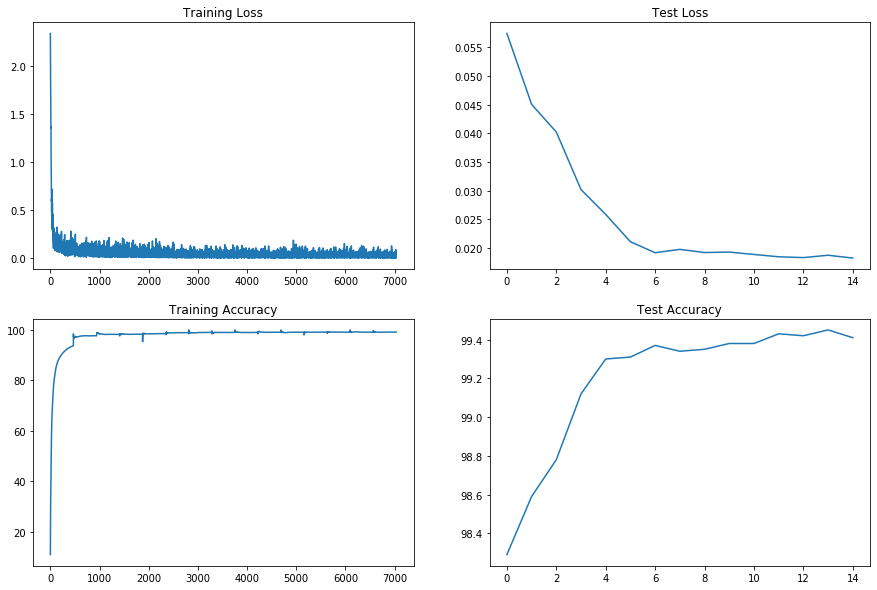

In [0]:
## Plot the accuracy graphs 

import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

##